
# 第6章分词技术实操笔记本

分词基础演示与实现


In [2]:
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

1. BPE算法基础演示

In [3]:
def demonstrate_bpe_steps(corpus, max_merges=5):
    """
    演示BPE算法的基本步骤
    """
    print(f"初始语料: {corpus}")
    
    # 初始化词汇表为单个字符
    vocab = list(set(''.join(corpus)))
    print(f"初始词汇表: {vocab}")
    
    # 将语料转换为字符列表的列表
    corpus_tokens = [[c for c in text] for text in corpus]
    print(f"初始分词结果: {corpus_tokens}")
    
    # 记录每一步的合并情况
    merge_history = []
    
    # 迭代合并
    for merge_idx in range(max_merges):
        # 统计所有相邻词元对的频率
        pairs = defaultdict(int)
        for text in corpus_tokens:
            for i in range(len(text) - 1):
                pair = (text[i], text[i + 1])
                pairs[pair] += 1
        
        # 如果没有可合并的词元对，提前结束
        if not pairs:
            print("没有更多可合并的词元对")
            break
        
        # 选择频率最高的词元对
        best_pair = max(pairs, key=pairs.get)
        new_token = ''.join(best_pair)
        
        print(f"\n合并 #{merge_idx+1}: '{best_pair[0]}' + '{best_pair[1]}' -> '{new_token}' (频率: {pairs[best_pair]})")
        
        # 将新词元添加到词汇表
        vocab.append(new_token)
        print(f"更新后的词汇表: {vocab}")
        
        # 更新语料中的词元表示
        for i, text in enumerate(corpus_tokens):
            j = 0
            while j < len(text) - 1:
                if text[j] == best_pair[0] and text[j + 1] == best_pair[1]:
                    text[j] = new_token
                    text.pop(j + 1)
                else:
                    j += 1
        
        print(f"更新后的分词结果: {corpus_tokens}")
        
        # 记录这一步的合并情况
        merge_history.append((best_pair, new_token, pairs[best_pair]))
    
    return vocab, corpus_tokens, merge_history

# 测试用例1: 简单中文示例
corpus1 = ["低碳生活", "低碳出行", "低碳饮食"]
vocab1, tokens1, history1 = demonstrate_bpe_steps(corpus1, max_merges=5)

# 测试用例2: 英文示例
corpus2 = ["hello world", "hello there", "world peace"]
vocab2, tokens2, history2 = demonstrate_bpe_steps(corpus2, max_merges=5)

# 测试用例3: 中英混合示例
corpus3 = ["AI技术", "人工智能", "AI应用", "机器学习"]
vocab3, tokens3, history3 = demonstrate_bpe_steps(corpus3, max_merges=5)

初始语料: ['低碳生活', '低碳出行', '低碳饮食']
初始词汇表: ['出', '饮', '生', '碳', '行', '低', '活', '食']
初始分词结果: [['低', '碳', '生', '活'], ['低', '碳', '出', '行'], ['低', '碳', '饮', '食']]

合并 #1: '低' + '碳' -> '低碳' (频率: 3)
更新后的词汇表: ['出', '饮', '生', '碳', '行', '低', '活', '食', '低碳']
更新后的分词结果: [['低碳', '生', '活'], ['低碳', '出', '行'], ['低碳', '饮', '食']]

合并 #2: '低碳' + '生' -> '低碳生' (频率: 1)
更新后的词汇表: ['出', '饮', '生', '碳', '行', '低', '活', '食', '低碳', '低碳生']
更新后的分词结果: [['低碳生', '活'], ['低碳', '出', '行'], ['低碳', '饮', '食']]

合并 #3: '低碳生' + '活' -> '低碳生活' (频率: 1)
更新后的词汇表: ['出', '饮', '生', '碳', '行', '低', '活', '食', '低碳', '低碳生', '低碳生活']
更新后的分词结果: [['低碳生活'], ['低碳', '出', '行'], ['低碳', '饮', '食']]

合并 #4: '低碳' + '出' -> '低碳出' (频率: 1)
更新后的词汇表: ['出', '饮', '生', '碳', '行', '低', '活', '食', '低碳', '低碳生', '低碳生活', '低碳出']
更新后的分词结果: [['低碳生活'], ['低碳出', '行'], ['低碳', '饮', '食']]

合并 #5: '低碳出' + '行' -> '低碳出行' (频率: 1)
更新后的词汇表: ['出', '饮', '生', '碳', '行', '低', '活', '食', '低碳', '低碳生', '低碳生活', '低碳出', '低碳出行']
更新后的分词结果: [['低碳生活'], ['低碳出行'], ['低碳', '饮', '食']]
初始语料: ['hello world', 'he

2. 实现完整的minBPE分词器


In [4]:
class MinBPETokenizer:
    def __init__(self):
        self.encoder = {}  # 从词元到ID的映射
        self.decoder = {}  # 从ID到词元的映射
        self.vocab = []    # 词汇表
        self.special_tokens = {
            "<PAD>": 0,    # 填充标记
            "<BOS>": 1,    # 序列开始标记
            "<EOS>": 2,    # 序列结束标记
            "<UNK>": 3     # 未知词标记
        }
    
    def train(self, corpus, vocab_size=1000, min_frequency=2, verbose=False):
        """训练分词器"""
        # 预处理语料
        processed_corpus = [self._preprocess_text(text) for text in corpus]
        
        # 初始化词汇表为单个字符
        chars = set()
        for text in processed_corpus:
            chars.update(text)
        self.vocab = list(self.special_tokens.keys()) + list(chars)
        
        # 将语料转换为字符列表的列表
        corpus_tokens = [[c for c in text] for text in processed_corpus]
        
        # 迭代合并直到达到目标词汇量
        iterator = range(vocab_size - len(self.vocab))
        if verbose:
            iterator = tqdm(iterator, desc="训练分词器")
            
        for _ in iterator:
            # 统计所有相邻词元对的频率
            pairs = defaultdict(int)
            for text in corpus_tokens:
                for i in range(len(text) - 1):
                    pair = (text[i], text[i + 1])
                    pairs[pair] += 1
            
            # 过滤低频词元对
            pairs = {pair: freq for pair, freq in pairs.items() if freq >= min_frequency}
            
            # 如果没有可合并的词元对，提前结束
            if not pairs:
                if verbose:
                    print("没有更多可合并的词元对，提前结束训练")
                break
            
            # 选择频率最高的词元对
            best_pair = max(pairs, key=pairs.get)
            new_token = ''.join(best_pair)
            
            # 将新词元添加到词汇表
            self.vocab.append(new_token)
            
            # 更新语料中的词元表示
            for i, text in enumerate(corpus_tokens):
                j = 0
                while j < len(text) - 1:
                    if text[j] == best_pair[0] and text[j + 1] == best_pair[1]:
                        text[j] = new_token
                        text.pop(j + 1)
                    else:
                        j += 1
        
        # 构建编码器和解码器
        self.encoder = {token: i for i, token in enumerate(self.vocab)}
        self.decoder = {i: token for i, token in enumerate(self.vocab)}
        
        return self
    
    def encode(self, text):
        """将文本编码为词元ID序列"""
        text = self._preprocess_text(text)
        
        # 贪婪分词
        tokens = []
        i = 0
        while i < len(text):
            # 尝试匹配最长的词元
            matched = False
            for j in range(min(100, len(text) - i), 0, -1):  # 限制最大词元长度为100
                if text[i:i+j] in self.encoder:
                    tokens.append(self.encoder[text[i:i+j]])
                    i += j
                    matched = True
                    break
            
            # 如果没有匹配到任何词元，使用未知词标记
            if not matched:
                tokens.append(self.special_tokens["<UNK>"])
                i += 1
        
        return tokens
    
    def decode(self, ids):
        """将词元ID序列解码为文本"""
        tokens = [self.decoder.get(id, "<UNK>") for id in ids]
        text = ''.join(tokens)
        return text
    
    def _preprocess_text(self, text):
        """预处理文本"""
        # 可以添加各种预处理步骤，如小写化、规范化等
        return text
    
    def tokenize(self, text):
        """将文本分词为词元（不转换为ID）"""
        text = self._preprocess_text(text)
        
        # 贪婪分词
        tokens = []
        i = 0
        while i < len(text):
            # 尝试匹配最长的词元
            matched = False
            for j in range(min(100, len(text) - i), 0, -1):
                if text[i:i+j] in self.encoder:
                    tokens.append(text[i:i+j])
                    i += j
                    matched = True
                    break
            
            # 如果没有匹配到任何词元，使用未知词标记
            if not matched:
                tokens.append("<UNK>")
                i += 1
        
        return tokens
    
    def vocabulary_size(self):
        """返回词汇表大小"""
        return len(self.vocab)
    
    def __len__(self):
        """返回词汇表大小"""
        return len(self.vocab)

3. 训练并测试分词器

In [5]:
# 准备训练语料
def generate_sample_corpus(n_samples=1000, min_len=5, max_len=50):
    """生成简单的训练语料"""
    import random
    
    # 中文常用字
    chinese_chars = "的一是了我不人在他有这个上们来到时大地为子中你说生国年着就那和要她出也得里后自以会家可下而过天去能对小多然于心学么之都好看起发当没成只如事把还用第样道想作种开美总从无情己面最女但现前些所同日手又行意动方期它头经长儿回位分爱老因很给名法间斯知世什两次使身者被高已亲其进此话常与活正感"
    
    # 英文常用词
    english_words = ["the", "of", "and", "a", "to", "in", "is", "you", "that", "it", "he", "was", "for", "on", "are", "as", "with", "his", "they", "I", "at", "be", "this", "have", "from", "or", "one", "had", "by", "word", "but", "not", "what", "all", "were", "we", "when", "your", "can", "said", "there", "use", "an", "each", "which", "she", "do", "how", "their", "if", "will", "up", "other", "about", "out", "many", "then", "them", "these", "so", "some", "her", "would", "make", "like", "him", "into", "time", "has", "look", "two", "more", "write", "go", "see", "number", "no", "way", "could", "people", "my", "than", "first", "water", "been", "call", "who", "oil", "its", "now", "find", "long", "down", "day", "did", "get", "come", "made", "may", "part"]
    
    # 标点符号
    puncts = "，。！？；：""''「」【】《》（）,.:;!?[](){}"
    
    corpus = []
    for _ in range(n_samples):
        # 决定生成中文、英文或混合文本
        text_type = random.choice(["chinese", "english", "mixed"])
        
        length = random.randint(min_len, max_len)
        text = ""
        
        if text_type == "chinese":
            # 生成中文文本
            for _ in range(length):
                if random.random() < 0.1:  # 10%几率生成标点
                    text += random.choice(puncts)
                else:
                    text += random.choice(chinese_chars)
        elif text_type == "english":
            # 生成英文文本
            words = []
            while len(' '.join(words)) < length:
                words.append(random.choice(english_words))
                if random.random() < 0.1:  # 10%几率添加标点
                    words[-1] += random.choice(puncts)
            text = ' '.join(words)
            text = text[:length]
        else:
            # 生成混合文本
            words = []
            while len(''.join(words)) < length:
                if random.random() < 0.5:  # 50%几率生成中文
                    words.append(random.choice(chinese_chars))
                else:
                    words.append(random.choice(english_words))
                if random.random() < 0.1:  # 10%几率添加标点
                    words.append(random.choice(puncts))
            text = ''.join(words)
            text = text[:length]
        
        corpus.append(text)
    
    return corpus

# 生成训练语料
train_corpus = generate_sample_corpus(n_samples=1000, min_len=10, max_len=100)
print(f"生成了{len(train_corpus)}条语料样本")
print("样本示例:")
for i in range(5):
    print(f"  {train_corpus[i]}")

# 训练分词器
tokenizer = MinBPETokenizer()
tokenizer.train(train_corpus, vocab_size=300, min_frequency=2, verbose=True)

print(f"\n分词器训练完成，词汇量: {tokenizer.vocabulary_size()}")
print("词汇表示例(前20个):")
for i, token in enumerate(tokenizer.vocab[:20]):
    print(f"  ID {i}: {token}")

生成了1000条语料样本
样本示例:
  there an more which these do can more into par
  my[美然没一把也sheabout老ofhowcan一常'么numberlikehe用.斯也其已这gofirstlo
  numberhas作partonemayuphim国.maya
  成无出如美要人他己给儿世自后分所会之被国手么和经小两间这手给然子把美下?与发其无(家到者地过斯[为都是；也身老就着作常已同种亲间者法亲行:好长世来生上它总其第天
  as who has you what to as look to water its could his can that all has on


训练分词器:   0%|          | 0/105 [00:00<?, ?it/s]


分词器训练完成，词汇量: 300
词汇表示例(前20个):
  ID 0: <PAD>
  ID 1: <BOS>
  ID 2: <EOS>
  ID 3: <UNK>
  ID 4: 小
  ID 5: 人
  ID 6: 话
  ID 7: n
  ID 8: 子
  ID 9:  
  ID 10: 就
  ID 11: 使
  ID 12: 说
  ID 13: 后
  ID 14: 总
  ID 15: ?
  ID 16: 前
  ID 17: y
  ID 18: ：
  ID 19: 什


4. 测试分词效果

In [6]:
def visualize_tokenization(tokenizer, texts):
    """可视化分词结果"""
    for text in texts:
        tokens = tokenizer.tokenize(text)
        
        print(f"原文: {text}")
        print(f"分词: {tokens}")
        print(f"词元数: {len(tokens)}")
        
        # 编码和解码
        ids = tokenizer.encode(text)
        decoded = tokenizer.decode(ids)
        
        print(f"编码: {ids}")
        print(f"解码: {decoded}")
        print(f"解码是否与原文匹配: {decoded == text}")
        print("---")

# 测试用例
test_texts = [
    "人工智能正在改变世界",
    "机器学习是AI的一个子领域",
    "深度学习模型需要大量数据",
    "Natural language processing is fascinating",
    "The future of AI looks promising",
    "GPT模型可以生成自然流畅的文本",
    "AI与人类合作，共创美好未来"
]

visualize_tokenization(tokenizer, test_texts)

原文: 人工智能正在改变世界
分词: ['人', '<UNK>', '<UNK>', '能', '正', '在', '<UNK>', '<UNK>', '世', '<UNK>']
词元数: 10
编码: [5, 3, 3, 155, 23, 40, 3, 3, 22, 3]
解码: 人<UNK><UNK>能正在<UNK><UNK>世<UNK>
解码是否与原文匹配: False
---
原文: 机器学习是AI的一个子领域
分词: ['<UNK>', '<UNK>', '学', '<UNK>', '是', '<UNK>', 'I', '的', '一', '个', '子', '<UNK>', '<UNK>']
词元数: 13
编码: [3, 3, 115, 3, 152, 3, 118, 186, 112, 134, 8, 3, 3]
解码: <UNK><UNK>学<UNK>是<UNK>I的一个子<UNK><UNK>
解码是否与原文匹配: False
---
原文: 深度学习模型需要大量数据
分词: ['<UNK>', '<UNK>', '学', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '要', '大', '<UNK>', '<UNK>', '<UNK>']
词元数: 12
编码: [3, 3, 115, 3, 3, 3, 3, 55, 80, 3, 3, 3]
解码: <UNK><UNK>学<UNK><UNK><UNK><UNK>要大<UNK><UNK><UNK>
解码是否与原文匹配: False
---
原文: Natural language processing is fascinating
分词: ['<UNK>', 'at', 'u', 'r', 'a', 'l', ' ', 'l', 'an', 'g', 'u', 'a', 'ge', ' ', 'p', 'r', 'o', 'c', 'e', 's', 's', 'in', 'g', ' ', 'i', 's ', 'f', 'as', 'c', 'in', 'at', 'in', 'g']
词元数: 33
编码: [3, 218, 183, 159, 132, 28, 9, 28, 200, 47, 183, 132, 289, 9, 54, 159, 42, 125, 

5. 多语言分词器实现

In [7]:
class MultilingualTokenizer(MinBPETokenizer):
    def __init__(self):
        super().__init__()
        self.language_specific_preprocessing = {
            'en': self._preprocess_english,
            'zh': self._preprocess_chinese,
            # 可以添加更多语言的预处理函数
        }
    
    def _preprocess_english(self, text):
        # 英文特定的预处理，如处理缩写、标点等
        text = re.sub(r"([.!?])", r" \1", text)  # 在标点符号前添加空格
        text = re.sub(r"[^a-zA-Z0-9.!?]+", " ", text)  # 规范化空格
        return text.lower()  # 小写化
    
    def _preprocess_chinese(self, text):
        # 中文特定的预处理，如处理全角符号等
        text = re.sub(r"[【】「」『』]", "", text)  # 移除特定括号
        return text  # 中文通常不需要小写化
    
    def _detect_language(self, text):
        # 简单的语言检测，实际应用中可能需要更复杂的算法
        if re.search(r'[\u4e00-\u9fff]', text):
            return 'zh'  # 包含汉字，判断为中文
        else:
            return 'en'  # 默认为英文
    
    def _preprocess_text(self, text):
        # 根据检测到的语言选择相应的预处理函数
        lang = self._detect_language(text)
        if lang in self.language_specific_preprocessing:
            return self.language_specific_preprocessing[lang](text)
        else:
            return super()._preprocess_text(text)

# 训练多语言分词器
multilingual_tokenizer = MultilingualTokenizer()
multilingual_tokenizer.train(train_corpus, vocab_size=300, min_frequency=2, verbose=True)

# 测试多语言分词器
print("\n多语言分词器测试:")
visualize_tokenization(multilingual_tokenizer, test_texts)

训练分词器:   0%|          | 0/109 [00:00<?, ?it/s]


多语言分词器测试:
原文: 人工智能正在改变世界
分词: ['人', '<UNK>', '<UNK>', '能', '正', '在', '<UNK>', '<UNK>', '世', '<UNK>']
词元数: 10
编码: [5, 3, 3, 151, 23, 40, 3, 3, 22, 3]
解码: 人<UNK><UNK>能正在<UNK><UNK>世<UNK>
解码是否与原文匹配: False
---
原文: 机器学习是AI的一个子领域
分词: ['<UNK>', '<UNK>', '学', '<UNK>', '是', '<UNK>', 'I', '的', '一', '个', '子', '<UNK>', '<UNK>']
词元数: 13
编码: [3, 3, 113, 3, 148, 3, 115, 182, 110, 131, 8, 3, 3]
解码: <UNK><UNK>学<UNK>是<UNK>I的一个子<UNK><UNK>
解码是否与原文匹配: False
---
原文: 深度学习模型需要大量数据
分词: ['<UNK>', '<UNK>', '学', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '要', '大', '<UNK>', '<UNK>', '<UNK>']
词元数: 12
编码: [3, 3, 113, 3, 3, 3, 3, 55, 79, 3, 3, 3]
解码: <UNK><UNK>学<UNK><UNK><UNK><UNK>要大<UNK><UNK><UNK>
解码是否与原文匹配: False
---
原文: Natural language processing is fascinating
分词: ['n', 'at', 'u', 'r', 'a', 'l', ' ', 'l', 'an', 'g', 'u', 'a', 'ge', ' ', 'p', 'r', 'o', 'c', 'e', 's', 's', 'in', 'g', ' ', 'i', 's ', 'f', 'a', 's', 'c', 'in', 'at', 'in', 'g']
词元数: 34
编码: [7, 228, 179, 155, 129, 28, 9, 28, 196, 47, 179, 129, 285, 9, 54, 155

6. 使用特殊标记实现风格和情感控制

In [8]:
def add_special_tokens(tokenizer, token_types):
    """向分词器添加特殊标记"""
    for type_name, tokens in token_types.items():
        print(f"添加{type_name}标记:")
        for token in tokens:
            special_token = f"<{token}>"
            if special_token not in tokenizer.encoder:
                tokenizer.vocab.append(special_token)
                token_id = len(tokenizer.encoder)
                tokenizer.encoder[special_token] = token_id
                tokenizer.decoder[token_id] = special_token
                print(f"  添加标记: {special_token}, ID: {token_id}")
    
    return tokenizer

# 添加各种特殊标记
special_token_types = {
    "风格": ["formal", "casual", "poetic", "humorous"],
    "情感": ["happy", "sad", "angry", "calm", "tense"],
    "角色": ["narrator", "protagonist", "antagonist", "sidekick"],
    "故事结构": ["intro", "rising_action", "climax", "falling_action", "resolution"]
}

tokenizer = add_special_tokens(tokenizer, special_token_types)

# 测试使用特殊标记
def encode_with_special_token(tokenizer, text, token_type, token_value):
    """使用特殊标记编码文本"""
    special_token = f"<{token_value}>"
    token_id = tokenizer.encoder.get(special_token)
    if token_id is None:
        raise ValueError(f"未知的{token_type}标记: {token_value}")
    
    # 在文本开头添加特殊标记
    normal_ids = tokenizer.encode(text)
    ids = [token_id] + normal_ids
    
    print(f"原文: {text}")
    print(f"添加{token_type}标记 <{token_value}>")
    print(f"编码: {ids}")
    
    # 解码(包含特殊标记)
    decoded = tokenizer.decode(ids)
    print(f"解码: {decoded}")
    
    return ids

# 测试特殊标记的使用
print("\n使用风格标记:")
encode_with_special_token(tokenizer, "这是一个美丽的故事", "风格", "poetic")

print("\n使用情感标记:")
encode_with_special_token(tokenizer, "突然，一声巨响打破了寂静", "情感", "tense")

print("\n使用角色标记:")
encode_with_special_token(tokenizer, "我不会让你得逞的！", "角色", "antagonist")

print("\n使用故事结构标记:")
encode_with_special_token(tokenizer, "就这样，他们过上了幸福的生活", "故事结构", "resolution")

添加风格标记:
  添加标记: <formal>, ID: 300
  添加标记: <casual>, ID: 301
  添加标记: <poetic>, ID: 302
  添加标记: <humorous>, ID: 303
添加情感标记:
  添加标记: <happy>, ID: 304
  添加标记: <sad>, ID: 305
  添加标记: <angry>, ID: 306
  添加标记: <calm>, ID: 307
  添加标记: <tense>, ID: 308
添加角色标记:
  添加标记: <narrator>, ID: 309
  添加标记: <protagonist>, ID: 310
  添加标记: <antagonist>, ID: 311
  添加标记: <sidekick>, ID: 312
添加故事结构标记:
  添加标记: <intro>, ID: 313
  添加标记: <rising_action>, ID: 314
  添加标记: <climax>, ID: 315
  添加标记: <falling_action>, ID: 316
  添加标记: <resolution>, ID: 317

使用风格标记:
原文: 这是一个美丽的故事
添加风格标记 <poetic>
编码: [302, 25, 152, 112, 134, 166, 3, 186, 3, 182]
解码: <poetic>这是一个美<UNK>的<UNK>事

使用情感标记:
原文: 突然，一声巨响打破了寂静
添加情感标记 <tense>
编码: [308, 3, 95, 65, 112, 3, 3, 3, 3, 3, 129, 3, 3]
解码: <tense><UNK>然，一<UNK><UNK><UNK><UNK><UNK>了<UNK><UNK>

使用角色标记:
原文: 我不会让你得逞的！
添加角色标记 <antagonist>
编码: [311, 26, 48, 123, 3, 173, 171, 3, 186, 94]
解码: <antagonist>我不会<UNK>你得<UNK>的！

使用故事结构标记:
原文: 就这样，他们过上了幸福的生活
添加故事结构标记 <resolution>
编码: [317, 10, 25, 136, 65, 3

[317, 10, 25, 136, 65, 34, 66, 85, 61, 129, 3, 3, 186, 145, 162]

7. 分词器性能分析

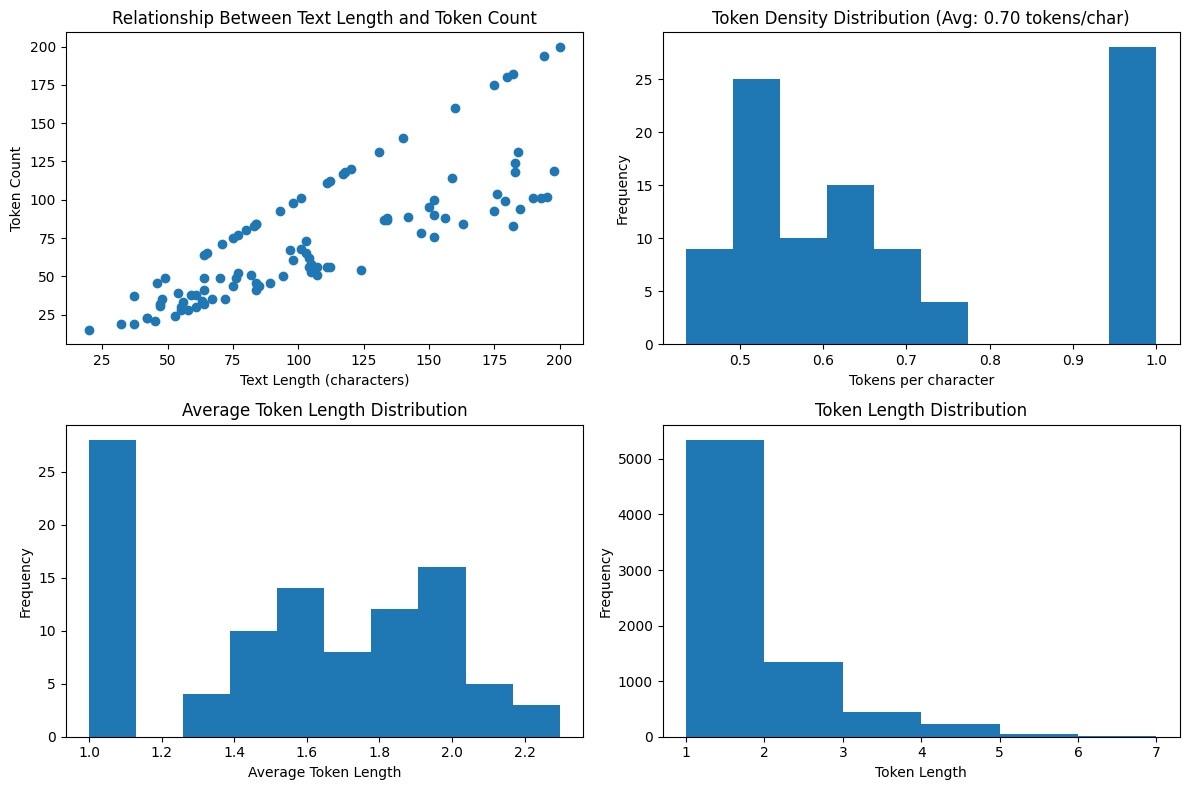

平均每字符词元数: 0.7007


In [10]:
def analyze_tokenizer_performance(tokenizer, test_texts):
    """分析分词器性能"""
    # 计算平均分词率
    total_chars = sum(len(text) for text in test_texts)
    total_tokens = sum(len(tokenizer.tokenize(text)) for text in test_texts)
    avg_tokens_per_char = total_tokens / total_chars
    
    # 统计各文本的分词结果
    tokenization_stats = []
    for text in test_texts:
        tokens = tokenizer.tokenize(text)
        tokenization_stats.append({
            'text_length': len(text),
            'token_count': len(tokens),
            'tokens_per_char': len(tokens) / len(text),
            'avg_token_length': sum(len(t) for t in tokens) / len(tokens) if tokens else 0
        })
    
    # 可视化
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.scatter([s['text_length'] for s in tokenization_stats], 
                [s['token_count'] for s in tokenization_stats])
    # plt.xlabel('文本长度 (字符)')
    # plt.ylabel('词元数量')
    # plt.title('文本长度与词元数量关系')
    plt.xlabel('Text Length (characters)')
    plt.ylabel('Token Count')
    plt.title('Relationship Between Text Length and Token Count')
    
    plt.subplot(2, 2, 2)
    plt.hist([s['tokens_per_char'] for s in tokenization_stats], bins=10)
    # plt.xlabel('每字符词元数')
    # plt.ylabel('频率')
    # plt.title(f'词元密度分布 (平均: {avg_tokens_per_char:.2f} tokens/char)')
    plt.xlabel('Tokens per character')  
    plt.ylabel('Frequency')  
    plt.title(f'Token Density Distribution (Avg: {avg_tokens_per_char:.2f} tokens/char)')  
    
    plt.subplot(2, 2, 3)
    plt.hist([s['avg_token_length'] for s in tokenization_stats], bins=10)
    # plt.xlabel('平均词元长度')
    # plt.ylabel('频率')
    # plt.title('平均词元长度分布')
    plt.xlabel('Average Token Length')  
    plt.ylabel('Frequency')  
    plt.title('Average Token Length Distribution')  
    
    plt.subplot(2, 2, 4)
    token_lengths = []
    for text in test_texts:
        tokens = tokenizer.tokenize(text)
        token_lengths.extend([len(t) for t in tokens])
    plt.hist(token_lengths, bins=range(1, max(token_lengths)+2))
    # plt.xlabel('词元长度')
    # plt.ylabel('频率')
    # plt.title('词元长度分布')
    plt.xlabel('Token Length')  
    plt.ylabel('Frequency')  
    plt.title('Token Length Distribution')  
    
    plt.tight_layout()
    plt.show()
    
    return {
        'avg_tokens_per_char': avg_tokens_per_char,
        'tokenization_stats': tokenization_stats
    }

# 生成更多测试样本
test_corpus = generate_sample_corpus(n_samples=100, min_len=20, max_len=200)
performance_results = analyze_tokenizer_performance(tokenizer, test_corpus)

print(f"平均每字符词元数: {performance_results['avg_tokens_per_char']:.4f}")

8. 实际应用：故事片段生成与分析

In [ ]:
story_samples = [
    """从前，有一个小村庄，村子里住着一位老渔夫。他每天都会划着小船到海上捕鱼。
    一天，天空突然乌云密布，电闪雷鸣。老渔夫知道一场暴风雨即将来临，他急忙划船返回岸边。
    就在这时，他看到海面上有一个闪闪发光的物体。好奇心驱使他靠近一看，原来是一个神秘的宝箱。""",
    
    """在未来的2150年，人类已经能够在火星上建立殖民地。
    艾莉是第一批在火星出生的孩子之一。她从未见过地球，只能通过全息影像了解那个蓝色的星球。
    在她15岁生日那天，她收到了一份特殊的礼物——一张前往地球的单程票。""",
    
    """The ancient forest stood silent as the morning mist swirled among the towering trees. 
    Maya had been tracking the mythical white deer for three days now, following faint tracks and listening to the whispers of the forest.
    According to the legend, whoever finds the white deer would be granted a single wish."""
]

print("故事片段分词分析:")
for i, story in enumerate(story_samples):
    print(f"\n故事 #{i+1}:")
    print(story)
    print("\n分词结果:")
    tokens = tokenizer.tokenize(story)
    print(tokens)
    print(f"原文字符数: {len(story)}, 分词数: {len(tokens)}, 压缩比: {len(tokens)/len(story):.2f}")

故事片段分词分析:

故事 #1:
从前，有一个小村庄，村子里住着一位老渔夫。他每天都会划着小船到海上捕鱼。
    一天，天空突然乌云密布，电闪雷鸣。老渔夫知道一场暴风雨即将来临，他急忙划船返回岸边。
    就在这时，他看到海面上有一个闪闪发光的物体。好奇心驱使他靠近一看，原来是一个神秘的宝箱。

分词结果:
['从', '前', '，', '有', '一', '个', '小', '<UNK>', '<UNK>', '，', '<UNK>', '子', '里', '<UNK>', '着', '一', '位', '老', '<UNK>', '<UNK>', '。', '他', '<UNK>', '天', '都', '会', '<UNK>', '着', '小', '<UNK>', '到', '<UNK>', '上', '<UNK>', '<UNK>', '。', '<UNK>', ' ', ' ', ' ', ' ', '一', '天', '，', '天', '<UNK>', '<UNK>', '然', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '，', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '。', '老', '<UNK>', '<UNK>', '知', '道', '一', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '来', '<UNK>', '，', '他', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '回', '<UNK>', '<UNK>', '。', '<UNK>', ' ', ' ', ' ', ' ', '就', '在', '这', '时', '，', '他', '看', '到', '<UNK>', '面', '上', '有', '一', '个', '<UNK>', '<UNK>', '发', '<UNK>', '的', '<UNK>', '<UNK>', '。', '好', '<UNK>', '心', '<UNK>', '使', '他', '<UNK>', '<UNK>', '一', '看', '，', '<UNK>', '来', '是', '一', '个', '<UNK>'

9. 与现有分词器对比

In [14]:
try:
    from transformers import AutoTokenizer
    
    # 加载预训练分词器
    gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2")
    bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    
    def compare_with_pretrained_tokenizers(text, our_tokenizer):
        """与预训练分词器对比"""
        print(f"原文: {text}")
        print(f"字符数: {len(text)}")
        
        # 我们的分词器
        our_tokens = our_tokenizer.tokenize(text)
        print(f"\n我们的分词器:")
        print(f"词元数: {len(our_tokens)}")
        print(f"词元: {our_tokens}")
        
        # GPT-2分词器
        gpt2_tokens = gpt2_tokenizer.tokenize(text)
        print(f"\nGPT-2分词器:")
        print(f"词元数: {len(gpt2_tokens)}")
        print(f"词元: {gpt2_tokens}")
        
        # BERT分词器
        bert_tokens = bert_tokenizer.tokenize(text)
        print(f"\nBERT分词器:")
        print(f"词元数: {len(bert_tokens)}")
        print(f"词元: {bert_tokens}")
    
    # 测试英文文本
    compare_with_pretrained_tokenizers(
        "The quick brown fox jumps over the lazy dog.",
        tokenizer
    )
    print("#"*30)
    # 尝试混合文本
    compare_with_pretrained_tokenizers(
        "AI技术正在快速发展，transformers模型尤为突出。",
        tokenizer
    )
    
except ImportError:
    print("需要安装transformers库进行对比测试: pip install transformers")

原文: The quick brown fox jumps over the lazy dog.
字符数: 44

我们的分词器:
词元数: 35
词元: ['<UNK>', 'h', 'e ', '<UNK>', 'u', 'i', 'c', 'k', ' ', 'b', 'r', 'ow', 'n', ' ', 'f', 'o', '<UNK>', ' ', '<UNK>', 'um', 'p', 's ', 'o', 'v', 'er', ' the', ' ', 'l', 'a', '<UNK>', 'y ', 'd', 'o', 'g', '.']

GPT-2分词器:
词元数: 10
词元: ['The', 'Ġquick', 'Ġbrown', 'Ġfox', 'Ġjumps', 'Ġover', 'Ġthe', 'Ġlazy', 'Ġdog', '.']

BERT分词器:
词元数: 10
词元: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']
##############################
原文: AI技术正在快速发展，transformers模型尤为突出。
字符数: 30

我们的分词器:
词元数: 26
词元: ['<UNK>', 'I', '<UNK>', '<UNK>', '正', '在', '<UNK>', '<UNK>', '发', '<UNK>', '，', 't', 'r', 'an', 's', 'for', 'm', 'er', 's', '<UNK>', '<UNK>', '<UNK>', '为', '<UNK>', '出', '。']

GPT-2分词器:
词元数: 40
词元: ['AI', 'æ', 'Ĭ', 'Ģ', 'æľ', '¯', 'æŃ', '£', 'åľ', '¨', 'å¿', '«', 'éĢ', 'Ł', 'åı', 'ĳ', 'å', '±', 'ķ', 'ï', '¼', 'Į', 'transform', 'ers', 'æ', '¨', '¡', 'å', 'ŀ', 'ĭ', 'å°', '¤', 'ä¸', 'º', 'ç', 'ª', 'ģ', 'åĩ', 'º', '

10. 练习与探索

词汇量对分词效果的影响:

词汇量: 50
词元数: 43
词元: ['人', '<UNK>', '<UNK>', '能', '和', '<UNK>', '<UNK>', '学', '<UNK>', '正', '在', '<UNK>', '<UNK>', '我', '们', '的', '生', '活', '方', '<UNK>', '，', '从', '<UNK>', '能', '手', '<UNK>', '到', '自', '动', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '，', '这', '些', '<UNK>', '<UNK>', '无', '<UNK>', '不', '在', '。']

词汇量: 100
词元数: 43
词元: ['人', '<UNK>', '<UNK>', '能', '和', '<UNK>', '<UNK>', '学', '<UNK>', '正', '在', '<UNK>', '<UNK>', '我', '们', '的', '生', '活', '方', '<UNK>', '，', '从', '<UNK>', '能', '手', '<UNK>', '到', '自', '动', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '，', '这', '些', '<UNK>', '<UNK>', '无', '<UNK>', '不', '在', '。']

词汇量: 200
词元数: 43
词元: ['人', '<UNK>', '<UNK>', '能', '和', '<UNK>', '<UNK>', '学', '<UNK>', '正', '在', '<UNK>', '<UNK>', '我', '们', '的', '生', '活', '方', '<UNK>', '，', '从', '<UNK>', '能', '手', '<UNK>', '到', '自', '动', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '，', '这', '些', '<UNK>', '<UNK>', '无', '<UNK>', '不', '在', '。']

词汇量: 500
词元数: 43
词元: ['人', '<UNK>', '<UNK>', '能', '和', '<UNK>', '<UNK

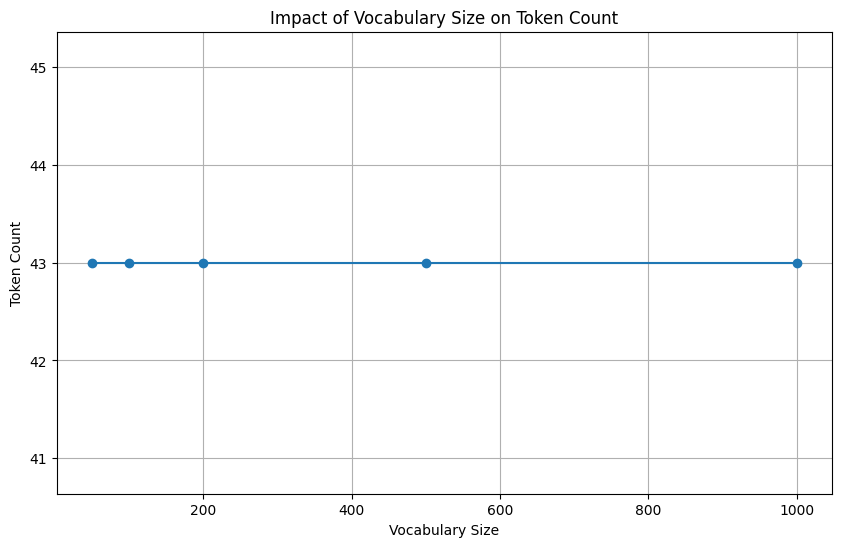

In [16]:
# 练习1: 尝试不同词汇量对分词效果的影响
def experiment_vocab_size():
    test_text = "人工智能和机器学习正在改变我们的生活方式，从智能手机到自动驾驶汽车，这些技术无处不在。"
    
    vocab_sizes = [50, 100, 200, 500, 1000]
    results = []
    
    for size in vocab_sizes:
        temp_tokenizer = MinBPETokenizer()
        temp_tokenizer.train(train_corpus, vocab_size=size, min_frequency=2)
        
        tokens = temp_tokenizer.tokenize(test_text)
        results.append({
            'vocab_size': size,
            'token_count': len(tokens),
            'tokens': tokens
        })
    
    # 输出结果
    print("词汇量对分词效果的影响:")
    for result in results:
        print(f"\n词汇量: {result['vocab_size']}")
        print(f"词元数: {result['token_count']}")
        print(f"词元: {result['tokens']}")
    
    # 可视化
    plt.figure(figsize=(10, 6))
    plt.plot([r['vocab_size'] for r in results], [r['token_count'] for r in results], marker='o')
    # plt.xlabel('词汇量大小')
    # plt.ylabel('词元数量')
    # plt.title('词汇量大小对词元数量的影响')
    plt.xlabel('Vocabulary Size')  
    plt.ylabel('Token Count')  
    plt.title('Impact of Vocabulary Size on Token Count')  
    plt.grid(True)
    plt.show()

# 运行词汇量实验
experiment_vocab_size()



In [18]:
# 练习2: 设计一个简单的故事生成场景
def story_generation_scenario():
    print("故事生成场景示例:")
    
    # 使用特殊标记定义故事参数
    story_params = {
        'style': 'poetic',
        'emotion': 'mysterious',
        'structure': 'intro'
    }
    
    # 构建提示
    prompt = "月光洒在古老的城堡上"
    
    # 编码带有特殊标记的提示
    style_token = f"<{story_params['style']}>"
    emotion_token = f"<{story_params['emotion']}>"
    structure_token = f"<{story_params['structure']}>"
    
    tokens = tokenizer.tokenize(prompt)
    special_tokens = [style_token, emotion_token, structure_token]
    
    print(f"故事参数:")
    print(f"  风格: {story_params['style']}")
    print(f"  情感: {story_params['emotion']}")
    print(f"  结构: {story_params['structure']}")
    print(f"提示: {prompt}")
    print(f"特殊标记: {special_tokens}")
    print(f"分词结果: {tokens}")
    
    # 在实际应用中，这里会将编码后的标记序列传入语言模型生成故事
    print("\n在实际应用中，这些标记将指导语言模型生成符合特定风格和情感的故事开头...")

# 运行故事生成场景
story_generation_scenario()

故事生成场景示例:
故事参数:
  风格: poetic
  情感: mysterious
  结构: intro
提示: 月光洒在古老的城堡上
特殊标记: ['<poetic>', '<mysterious>', '<intro>']
分词结果: ['<UNK>', '<UNK>', '<UNK>', '在', '<UNK>', '老', '的', '<UNK>', '<UNK>', '上']

在实际应用中，这些标记将指导语言模型生成符合特定风格和情感的故事开头...


结论与讨论

# 总结与讨论
## 分词器总结与讨论

在本实验中，我们实现并测试了以下内容：

1. **BPE算法基础**：演示了BPE算法的工作原理和步骤
2. **完整的minBPE分词器**：实现了一个功能完整的分词器，包含训练、编码和解码功能
3. **多语言支持**：扩展了分词器以支持中英文混合文本
4. **特殊标记应用**：实现了风格、情感、角色和故事结构标记的添加和使用
5. **性能分析**：分析了分词器的性能指标
6. **实际应用**：展示了分词器在故事生成中的应用

### 主要发现：

1. BPE算法能够有效地从语料中学习子词单元，平衡了词汇量和分词效率
2. 词汇量大小对分词效果有显著影响，需要根据具体应用场景选择适当的词汇量
3. 特殊标记可以扩展分词器的功能，用于控制生成内容的风格、情感和结构
4. 多语言支持需要特殊的设计考虑，如语言检测和特定的预处理规则

### 未来改进方向：

1. 实现更高效的数据结构（如前缀树）来加速分词过程
2. 添加缓存机制减少重复计算
3. 增强对罕见词和特殊字符的处理能力
4. 实现更复杂的词汇裁剪策略，优化词汇表组成
5. 增加对更多语言的支持